In [5]:
# General imports
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import collections
import os
import time
import re
import itertools

# Data Science
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Plotting
from matplotlib.markers import MarkerStyle
from PIL import Image

from export_results import *
from utils import *
from scipy.stats import *
import pymysql.cursors

In [6]:
labels = ["1:1","1:2","1:4","1:6","1:10","1:25", "1:50", r"1:$10^2$", r"1:$10^3$", r"1:$10^6$"]
# like the ShuffleSplit strategy, stratified random splits do not guarantee 
#that all folds will be different, although this is still very likely for sizeable datasets

costs = np.array([2, 3, 4, 6, 10, 25, 50, 100, 1000, 1000000])
axis_costs = np.arange(1,11,1)
cxlim = [0.8, 10.15]

In [166]:
def load_results():

    results = []
    connection = pymysql.connect(host='localhost',
                             user='root',
                             password='',
                             db='agriculture_experiments',
                             charset='utf8')

    try:
        sql = \
        """
        SELECT id, n_experiment, nlp, algorithm, cost_ratio, prec AS `precision`, recall
        FROM results
        """
        results = pd.read_sql(sql, connection)
    except Exception as e:
        print(e)
    finally:
        connection.close()
        
    return results

def get_best(algorithm):
    accepted_results = data.loc[(data["algorithm"] == algorithm) & 
         (data["recall"] == data.loc[(data["algorithm"] == 
                                      algorithm)]["recall"].max())]

    return accepted_results.loc[(accepted_results["precision"] == \
                                 accepted_results.loc[(accepted_results["algorithm"] \
                                                                            == algorithm)]["precision"].max())]
def save_image(image, url='../images/', name = 'default'):
    image.savefig(url + name)
    Image.open(url + name + '.png').convert('L').save(url + name + '.png')
    
def plot_image(x, results, title="title", ylim = [0, 1.02], xlim = [2, 50.5], 
               colors="rgbmyc", name="name", labels=[], ylabel = "ylabel", 
               loc="better", markers=".,ov<>"):
    plt.figure(figsize=(14,13))
    plt.ylim(ylim)
    plt.xlim(xlim)
    plt.xlabel("Misclassification Cost Ratio")
    plt.ylabel(ylabel)
    plt.style.use('paper.mplstyle')
    
    filled_markers = ('<', 'D', 'o', '|', 'v', '>', 'p', 'd') #' '^', ', '>', '8', 's', 'p', '*', 'h', 'H', , 'd')
    fillstyles = ('full', 'full', 'full', 'full', 'top', 'none')

    i = 0
    for record in results:
        model_name = record[1] + "-" + record[2]
        plt.plot(x, record[0])
        marker = MarkerStyle(marker=filled_markers[i], fillstyle=fillstyles[i])
        plt.scatter(x, record[0], marker=marker, s=300, label=model_name)
        i+=1
    
    plt.xticks(x, labels, rotation='vertical')
    plt.legend(loc=loc, prop={'size':30})

    save_image(plt,'../images/', name)
    plt.show()

In [145]:
data = load_results()

In [106]:
bayes = data[data["algorithm"] == "Naive Bayes"]["recall"]
svm = data[data["algorithm"] == "SVM"]["recall"]

### Parametric

In [107]:
z_stat, p_val = ttest_ind(bayes, svm, equal_var=False)
if p_val < 0.05:
    print("Statistically significant different results")

Statistically significant different results


### Non-parametric

In [108]:
z_stat, p_val = wilcoxon(bayes, svm, zero_method='wilcox', correction=False)
if p_val < 0.05:
    print("Statistically significant different results")

Statistically significant different results


## Best result

In [109]:
accepted_results = data[data["recall"] == data["recall"].max()]
accepted_results[accepted_results["precision"] == accepted_results["precision"].max()]

,id,n_experiment,nlp,algorithm,cost_ratio,precision,recall
1030,1031,9,Bigrams,SVM,6,0.511351,1


In [110]:
accepted_results.loc[(accepted_results["nlp"] == "Bigrams") & (accepted_results["algorithm"] == "SVM") 
                     & (accepted_results["cost_ratio"] == 6)]

,id,n_experiment,nlp,algorithm,cost_ratio,precision,recall
1030,1031,9,Bigrams,SVM,6,0.511351,1
1034,1035,74,Bigrams,SVM,6,0.509829,1


## Best results

In [111]:
accepted_results[accepted_results["precision"] > 0.48].sort(["precision"], ascending=False)

,id,n_experiment,nlp,algorithm,cost_ratio,precision,recall
1030,1031,9,Bigrams,SVM,6,0.511351,1
1034,1035,74,Bigrams,SVM,6,0.509829,1
40,41,9,None,Naive Bayes,10,0.494311,1
342,343,9,Combination,Naive Bayes,10,0.493177,1
345,346,93,Combination,Naive Bayes,10,0.491014,1
343,344,74,Combination,Naive Bayes,10,0.489272,1
1044,1045,74,Bigrams,SVM,10,0.480656,1
1054,1055,74,Bigrams,SVM,25,0.480656,1
1064,1065,74,Bigrams,SVM,50,0.480656,1
1073,1074,74,Bigrams,SVM,100,0.480656,1


In [112]:
data1 = data.loc[(data["algorithm"] == "Naive Bayes") & (data["cost_ratio"] == 100)]["recall"]
data2 =  data.loc[(data["algorithm"] == "SVM") & (data["cost_ratio"] == 100)]["recall"]

z_stat, p_val = wilcoxon(data1, data2, zero_method='wilcox', correction=False)
if p_val < 0.001: # 0.05
    print("Statistically significant different results")

Statistically significant different results


## Best Result

In [128]:
get_best("Naive Bayes")

,id,n_experiment,nlp,algorithm,cost_ratio,precision,recall
40,41,9,None,Naive Bayes,10,0.494311,1


In [171]:
get_best("SVM")

,id,n_experiment,nlp,algorithm,cost_ratio,precision,recall
1030,1031,9,Bigrams,SVM,6,0.511351,1


In [129]:
get_best("Random Forest")

,id,n_experiment,nlp,algorithm,cost_ratio,precision,recall
698,699,12,Bigrams,Random Forest,1000000,0.725691,0.965359


In [142]:
def get_best_by_cost(important_metric, algorithm, plot_metric):
    best_rf_experiment = data.loc[(data["algorithm"] == algorithm) & 
         (data[important_metric] == data.loc[(data["algorithm"] == 
                                      algorithm)][important_metric].max())]["n_experiment"].values[0]
    
    best_rf_nlp = data.loc[(data["algorithm"] == algorithm) & 
         (data[important_metric] == data.loc[(data["algorithm"] == 
                                      algorithm)][important_metric].max())]["nlp"].values[0]
    
    return np.array(data.loc[(data["algorithm"] == algorithm) & 
         (data["n_experiment"] == best_rf_experiment) &
         (data["nlp"] == best_rf_nlp)][plot_metric].values), algorithm, best_rf_nlp

In [172]:
recalls = []
precisions = []
for m in ["Naive Bayes", "Random Forest", "SVM"]:
    recalls.append(get_best_by_cost("recall", m , "recall"))
    precisions.append(get_best_by_cost("recall", m , "precision"))

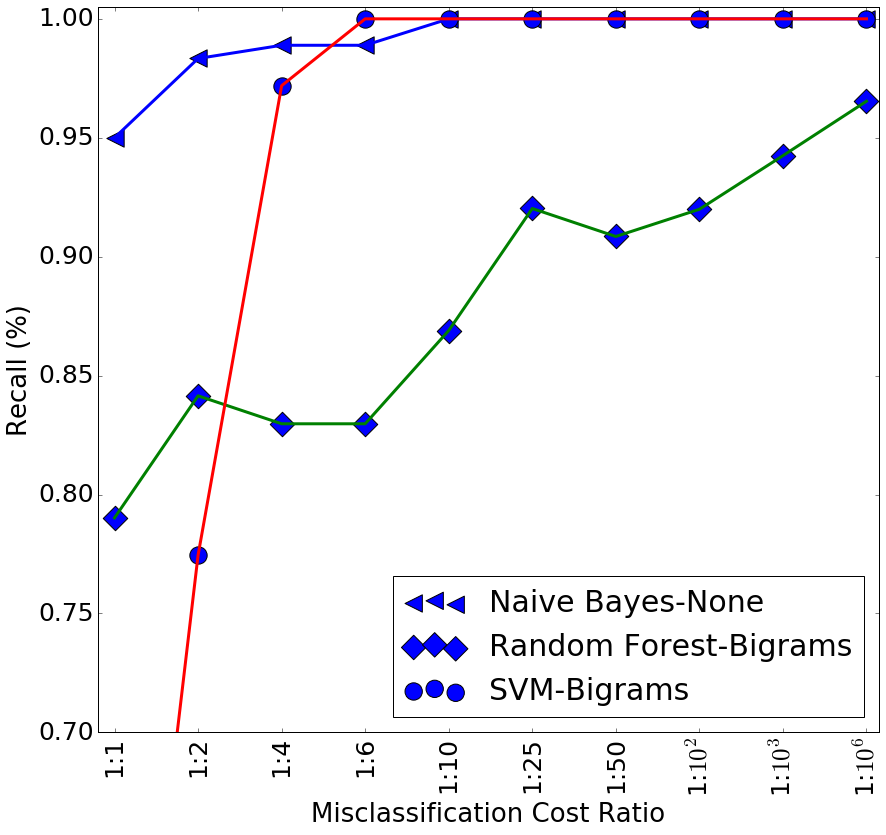

In [173]:
plot_image(axis_costs, recalls, title="RECALL", ylim = [0.70, 1.005], 
           xlim = cxlim, name="recall", labels=labels, ylabel="Recall (%)", 
           loc='lower righ', markers="<Do|")

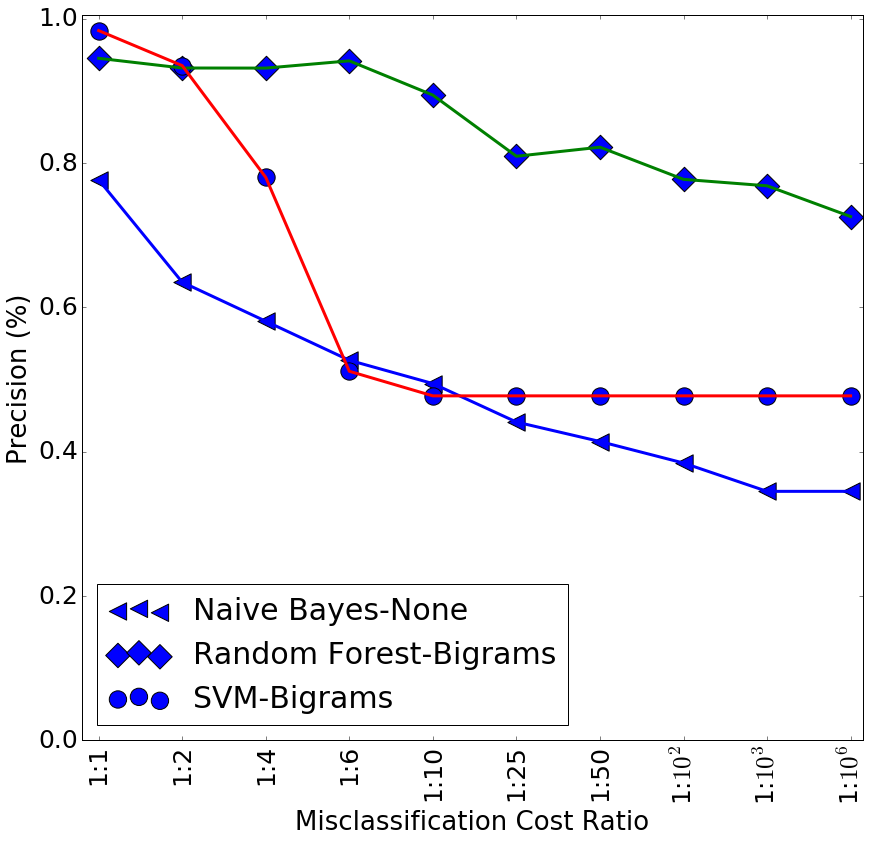

In [168]:
plot_image(axis_costs, precisions, title="RECALL", ylim = [0., 1.005], 
           xlim = cxlim, name="precision", labels=labels, ylabel="Precision (%)", 
           loc='lower righ', markers="<Do|")